# Shoe vs Sandal vs Boot

> [Data Source can be found here](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images)

This notebook is so far my first foray into machine learning without using the common datasets like MNIST. It focuses on demonstrating knowledge of PyTorch, the filesystem, and Matplotlib. Finally, it also shows knowledge on creating and using models for use in specific problems.

The dataset contains 15,000 images of shoes, sandals, and boots for classification problems. Each type contains a shoe, sandal, or a boot. The goal of the best model is to classify whether something is a shoe, a sandal, or a boot.

## 1. Exploring the Data

First off, we explore the dataset before performing data science techniques. Learning about the data can help us see what problems might come up before we train our first model. The goal of this step is to *feel* the data and make the further steps of the data science process much clearer.

The code below takes three random images from each folder and shows it to us. But first, let us set the `RANDOM_SEED` so that our results are reproducible.

In [1]:
RANDOM_SEED = 10

After doing so, we will set `DATA_PATH` to the location of our data files. Just extract everything in the folder into `data` and do not do any processing as the notebook will do that.

In [2]:
from pathlib import Path

DATA_PATH = Path("data")

The locations of each image file is listed below. 3 random images from each category is chosen and shown on the next section.

In [3]:
boots = list(DATA_PATH.glob("Boot/*.jpg"))
sandals = list(DATA_PATH.glob("Sandal/*.jpg"))
shoes = list(DATA_PATH.glob("Shoe/*.jpg"))

In [4]:
import random

random.seed(RANDOM_SEED)
random_images = [
    *random.sample(boots, k=3),
    *random.sample(sandals, k=3),
    *random.sample(shoes, k=3),
]
random_images[:3]

[WindowsPath('data/Boot/boot (710).jpg'),
 WindowsPath('data/Boot/boot (1238).jpg'),
 WindowsPath('data/Boot/boot (4160).jpg')]

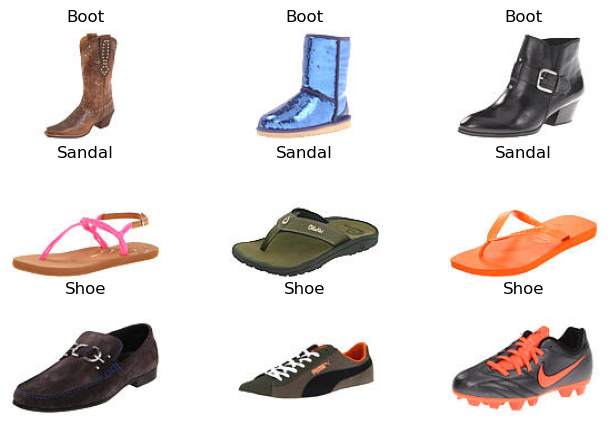

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))

for index, image in enumerate(random_images):
    current = Image.open(image)
    label = image.parent.stem

    plt.subplot(3, 3, index + 1)
    plt.imshow(current)
    plt.title(label)
    plt.axis(False)

From the above, it is clear to me what the differences between a boot, a sandal, and a shoe are. The boot has a higher shaft than the other two while sandals are the most open among all. I think that a machine learning model can definitely differentiate between the three.

## 2. Preparing the Data for Machine Learning

Because there are 15,000 samples of training and testing, I will split the data into the following:

- 80% Training
- 15% Validation
- 5% Testing

In absolute terms, there will be 12000 training samples, 2250 validation samples, and 750 testing samples. These will be split equally among the data using Scikit-Learn's `train_test_split`.

First, we import the modules we'll need and set the device we're going to use.

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
device

device(type='cuda')

To make things consistent, we must create a series of transforms for our data to work on. First, we resize the images to a 64 pixel height and 64 pixel width. Finally, we convert the image into a tensor for use by our neural network.

In [8]:
transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
transforms

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

### 2.1 Loading the Data

Next, we need to get all the data in the `data` folder using `ImageFolder`. This is pretty simple now since `torchvision` will take care of the details for us.

In [9]:
all_data = torchvision.datasets.ImageFolder(
    root=DATA_PATH,
    transform=transforms,
    target_transform=None,
)
all_data

Dataset ImageFolder
    Number of datapoints: 15000
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [10]:
all_data.class_to_idx

{'Boot': 0, 'Sandal': 1, 'Shoe': 2}

Due to the way the data is distributed, the 0th, 5000th, and 10000th index will show the Boot, Sandal, and the Shoe. Thus, let's take a look at the said items.

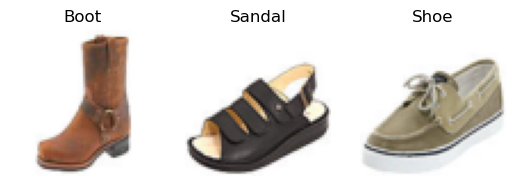

In [11]:
indexes = [0, 5000, 10000]

for i, data_index in enumerate(indexes):
    image, label = all_data[data_index]
    label = all_data.classes[label]

    plt.subplot(1, 3, i + 1)
    plt.imshow(image.permute((1, 2, 0)))
    plt.title(label)
    plt.axis(False)

### 2.2 Splitting the Data into Train, Validation, and Test sets

It seems that our dataset contains all the data. We should now split it into training, validation, and testing. This will consist of two phases:

1. Splitting the original dataset into training and testing. This will be an 80-20 split.
2. Splitting the testing subset into validation and testing. Since the ratio is 5-15, this will be akin to a 25-75 split.

To take advantage of `Subset`, we will focus on splitting the indices rather than the dataset.

In [12]:
# For reference, these are the indices of each dataset.
# Our goal is to split each equally for the Subset
# [0:5000] -> Boot
# [5000:10000] -> Sandal
# [10000:15000] -> Shoe

# SIZES
train_size = 0.8 * len(all_data) / 3
validation_size = 0.15 * len(all_data) / 3
test_size = 0.05 * len(all_data) / 3

train_size = round(train_size)
validation_size = round(validation_size)
test_size = round(test_size)

# RANGES
boot_range = range(0, 5000)
sandal_range = range(5000, 10000)
shoe_range = range(10000, 15000)

In [13]:
from sklearn.model_selection import train_test_split

# Get Training Indices
x_boot_train, x_boot_test, _boot_train, _boot_test = train_test_split(
    boot_range, range(0, 5000),
    shuffle=True,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

x_sandal_train, x_sandal_test, _sandal_train, _sandal_test = train_test_split(
    sandal_range, range(0, 5000),
    shuffle=True,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

x_shoe_train, x_shoe_test, _shoe_train, _shoe_test = train_test_split(
    shoe_range, range(0, 5000),
    shuffle=True,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

train_indices = [
    *x_boot_train,
    *x_sandal_train,
    *x_shoe_train,
]

# Get Validation and Test
# Note: 15-5 split. In other words, a 75-25 split
x_boot_validation, x_boot_test, _boot_validation, _boot_test = train_test_split(
    x_boot_test, range(len(x_boot_test)),
    shuffle=True,
    test_size=0.25,
    random_state=RANDOM_SEED,
)

x_sandal_validation, x_sandal_test, _sandal_validation, _sandal_test = train_test_split(
    x_sandal_test, range(len(x_sandal_test)),
    shuffle=True,
    test_size=0.25,
    random_state=RANDOM_SEED,
)

x_shoe_validation, x_shoe_test, _shoe_validation, _shoe_test = train_test_split(
    x_shoe_test, range(len(x_shoe_test)),
    shuffle=True,
    test_size=0.25,
    random_state=RANDOM_SEED,
)

validation_indices = [
    *x_boot_validation,
    *x_sandal_validation,
    *x_shoe_validation,
]

test_indices = [
    *x_boot_test,
    *x_sandal_test,
    *x_shoe_test,
]

# Validate the Lengths
len(train_indices), len(validation_indices), len(test_indices)

(12000, 2250, 750)

After getting the indices, we will use `Subset` to get the data from the original dataset.

In [14]:
from torch.utils.data import Subset

In [15]:
train_data = Subset(all_data, train_indices)
validation_data = Subset(all_data, validation_indices)
test_data = Subset(all_data, test_indices)

len(train_data), len(validation_data), len(test_data)

(12000, 2250, 750)

### 2.3 Putting datasets into a dataloader

With the above steps now complete, the only thing left to do for preparing the data to be used by the model is to put it into a dataloader. The training dataloader will have its data shuffled but the validation and test dataloaders will not.

In [16]:
from torch.utils.data import DataLoader

In [17]:
torch.manual_seed(RANDOM_SEED)
train_dataloader = DataLoader(
    dataset=train_data,
    shuffle=True,
    batch_size=32,
)

torch.manual_seed(RANDOM_SEED)
validation_dataloader = DataLoader(
    dataset=validation_data,
    shuffle=False,
    batch_size=32,
)

torch.manual_seed(RANDOM_SEED)
test_dataloader = DataLoader(
    dataset=test_data,
    shuffle=False,
    batch_size=32,
)

In [18]:
len(train_dataloader), len(validation_dataloader), len(test_dataloader)

(375, 71, 24)

## 3. Helper Functions

Below are a couple of helper functions for convenience in training and testing.

### 3.1 Result Types

The script below creates a few types that are expected from the results of helper functions. As type hints are used throughout the notebook, the below types allows for better documentation.

In [19]:
%%writefile helper_functions/result_types.py
"""
Contains types for results of certain functions
"""
import torch
from typing import TypedDict, List, Dict


class ModelResult(TypedDict):
    model: str
    loss: float
    acc: float


class TrainTestResult(TypedDict):
    model_states: List[Dict[str, torch.Tensor]]
    optimizer_states: List[Dict[str, torch.Tensor]]
    train: List[ModelResult]
    test: List[ModelResult]

Overwriting helper_functions/result_types.py


### 3.2 Train and Test Functions

The script below contains the training, testing, and the combination of the two.

In [20]:
%%writefile helper_functions/train_and_test.py
"""
Contains functionality for common tasks for each model
"""
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from helper_functions.result_types import ModelResult, TrainTestResult
from typing import Callable


def train_step(
        model: nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: nn.modules.loss._Loss,
        optimizer: torch.optim.Optimizer,
        accuracy_fn: Callable[..., float],
        device: torch.device,
) -> ModelResult:
    """
    This trains a model for one step. Use in a for loop for
    convenience purposes. For a complete train and test loop,
    use `train_and_test` instead.

    :param model: A model to be trained
    :param dataloader: A dataloader that contains the data
        for training the model
    :param loss_fn: A loss function that calculates the loss
        of a training model
    :param optimizer: An optimizer that optimizes the
        parameters of a model to better itself
    :param accuracy_fn: A function that calculates the
        accuracy of a model in predicting the result.
    :param device: The device in which the model should
        be trained. Ideally, this is a constant variable
    :return: A `ModelResult` for training data
    """
    model.train()

    total_loss = 0
    total_acc = 0

    for batch, (image, label) in enumerate(dataloader):
        image, label = image.to(device=device), label.to(device=device)

        preds_logits = model(image)
        preds = preds_logits.argmax(dim=1)

        loss = loss_fn(preds_logits, label)
        total_loss += loss
        acc = accuracy_fn(label.cpu(), preds.cpu())
        total_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 30 == 0:
            print(f"Batch {batch}: ({len(image) * batch} / {len(dataloader.dataset)})")

    return {
        "model": model.__class__.__name__,
        "loss": total_loss / len(dataloader),
        "acc": total_acc / len(dataloader),
    }


def test_step(
        model: nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: nn.modules.loss._Loss,
        optimizer: torch.optim.Optimizer,  # For consistency purposes
        accuracy_fn: Callable[..., float],
        device: torch.device,
) -> ModelResult:
    """
    This tests or validates a model for one step. Use in a
    for loop for convenience purposes. For a complete train
    and test loop, use `train_and_test` instead.

    :param model: A model to be tested or validated
    :param dataloader: A dataloader that contains the data
        for testing or validating the model
    :param loss_fn: A loss function that calculates the loss
        of a training model
    :param optimizer: An optimizer that optimizes the
        parameters of a model to better itself. Note that
        this will not be used by the function and *is in
        here for consistency purposes only*.
    :param accuracy_fn: A function that calculates the
        accuracy of a model in predicting the result.
    :param device: The device in which the model should
        be trained. Ideally, this is a constant variable
    :return: A `ModelResult` for testing or validation data
    """
    model.eval()

    total_loss = 0
    total_acc = 0

    for image, label in dataloader:
        with torch.inference_mode():
            image, label = image.to(device=device), label.to(device=device)

            preds_logits = model(image)
            preds = preds_logits.argmax(dim=1)

            loss = loss_fn(preds_logits, label)
            total_loss += loss
            acc = accuracy_fn(label.cpu(), preds.cpu())
            total_acc += acc

    return {
        "model": model.__class__.__name__,
        "loss": total_loss / len(dataloader),
        "acc": total_acc / len(dataloader),
    }


def train_and_test(
        model: nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        loss_fn: nn.modules.loss._Loss,
        optimizer: torch.optim.Optimizer,
        accuracy_fn: Callable[..., float],
        device: torch.device,
        epochs: int,
        previous: TrainTestResult,
) -> TrainTestResult:
    """
    This function combines both train and test functions in
    a single function. Use this so you don't have to write
    for loops over and over again.

    Note that this function does not contain a mechanism for
    early stopping. To find the most optimal model, you must
    manually find it.

    :param model: A model to be trained and tested
    :param dataloader: A dataloader that contains the data
        for testing or validating the model
    :param train_dataloader: A dataloader that contains the data
        for training the model
    :param test_dataloader: A dataloader that contains the data
        for testing or validating the model
    :param loss_fn: A loss function that calculates the loss
        of a training model
    :param optimizer: An optimizer that optimizes the
        parameters of a model to better itself. Note that
        this will not be used by the function and *is in
        here for consistency purposes only*.
    :param accuracy_fn: A function that calculates the
        accuracy of a model in predicting the result.
    :param device: The device in which the model should
        be trained. Ideally, this is a constant variable
    :param epochs: Number of epochs the model should be run
        for
    :param previous: A `TrainTestResult` of the previous run.
        This is useful if you want to resume training at a said
        point rather than starting over again.
    :return: A `TrainTestResult` for the said number of epochs.
    """

    model_states, optimizer_states = [], []
    train_results, test_results = [], []
    start_epoch = len(previous['test'])

    model.to(device=device)

    for epoch in tqdm(range(start_epoch, epochs)):
        train_details = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device,
        )
        train_loss = train_details['loss']
        train_acc = train_details['acc']

        test_details = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device,
        )
        test_loss = test_details['loss']
        test_acc = test_details['acc']

        train_results.append(train_details)
        test_results.append(test_details)
        model_states.append(model.state_dict())
        optimizer_states.append(optimizer.state_dict())

        print(f"Epoch {epoch}")
        print(f"--- Train | Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"--- Test  | Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    return {
        "model_states": [*previous['model_states'], *model_states],
        "optimizer_states": [*previous['optimizer_states'], *optimizer_states],
        "train": [*previous['train'], *train_results],
        "test": [*previous['test'], *test_results],
    }

Overwriting helper_functions/train_and_test.py


### 3.3 Evaluate Model Function

This is a script for evaluating a given dataset by plotting some predictions into the screen. The goal of this is to evaluate whether the errors a model is picking up on are reasonable. But it is also to see whether the model is actually learning or just guessing.

In [21]:
%%writefile helper_functions/evaluate.py
"""
Provides a function for evaluating a model on a given dataset
"""
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from typing import List


def eval_model(
        model: nn.Module,
        dataloader: DataLoader,
        real_labels: List[str],
        device: torch.device = torch.device("cpu"),
) -> None:
    """
    Evaluates the first iteration of the dataloader.
    If you want to evaluate a part of the dataloader, consider
    using the following script:

    ```python
    new_dataloader = DataLoader(
        dataset=old_dataloader.dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    ```

    :param model: The model to be evaluated
    :param dataloader: A dataloader of the dataset
    :param real_labels: A list of human readable labels
    :param device: The device of your choosing. Default is 'cpu'
    :return: Returns nothing
    """
    model.to(device=device)

    images, labels = next(iter(dataloader))
    images, labels = images.to(device=device), labels.to(device=device)

    plt.figure(figsize=(10, 8))

    with torch.inference_mode():
        preds = model(images)
        preds = preds.argmax(dim=1)

    for index, image in enumerate(images):
        real = labels[index]
        pred = preds[index]
        text_color = "green" if real == pred else "red"

        plt.subplot(4, 8, index + 1)
        plt.imshow(image.cpu().permute((1, 2, 0)))
        plt.title(
            f"Real: {real_labels[real]}\nPred: {real_labels[pred]}",
            c=text_color,
            fontsize=6,
        )
        plt.axis(False)

Overwriting helper_functions/evaluate.py


### 3.4 Plot Confusion Matrix Function

This plots the confusion matrix of a model to help determine where a model is usually predicting false positives.

In [22]:
%%writefile helper_functions/confusion_matrix.py
"""
Provides a function for evaluating a model's predictions
"""
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import List
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(
        model: nn.Module,
        dataloader: DataLoader,
        labels: List[str],
        device: torch.device = torch.device("cpu"),
) -> ConfusionMatrixDisplay:
    """
    This creates a plot of a confusion matrix for a model.
    To show the plot, use the following code:

    ```python
    conf_matrix = plot_confusion_matrix(model, dataloader, labels)
    conf_matrix.plot(cmap='gray', xticks_rotation='vertical')
    ```

    :param model: The model for the confusion_matrix
    :param dataloader: A dataloader containing validation
        or training data
    :param labels: Human readable labels
    :param device: The device where the script will run.
        Default is "cpu"
    :return: A `ConfusionMatrixDisplay`
    """

    y_true, y_pred = [], []

    model.to(device=device)
    model.eval()

    for image, label in dataloader:
        image, label = image.to(device=device), label.to(device=device)

        with torch.inference_mode():
            preds_logits = model(image)
            preds = preds_logits.argmax(dim=1)

            y_pred = [*y_pred, *preds.cpu()]
            y_true = [*y_true, *label.cpu()]

    y_pred = [labels[pred] for pred in y_pred]
    y_true = [labels[true] for true in y_true]

    return ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels,
        ),
        display_labels=labels,
    )

Overwriting helper_functions/confusion_matrix.py


### 3.5 Plot Model's Losses and Accuracy Function

This is a script that plots a model's train and test losses, and train and test accuracy in a graph.

In [23]:
%%writefile helper_functions/plot_loss.py
"""
Stores a function that plots the train and loss functions of a model
"""
import matplotlib.pyplot as plt
from helper_functions.result_types import TrainTestResult


def plot_loss(model_details: TrainTestResult) -> None:
    """
    Plots the train and test losses and accuracy of the model.

    :param model_details: A `TrainTestResult` of the model whose
        losses and accuracies you want to plot.
    :return: Returns nothing
    """
    model_train_loss, model_train_acc = [], []
    model_test_loss, model_test_acc = [], []

    for train_details, test_details in zip(model_details['train'], model_details['test']):
        model_train_loss.append(train_details['loss'].detach().cpu())
        model_train_acc.append(train_details['acc'])

        model_test_loss.append(test_details['loss'].detach().cpu())
        model_test_acc.append(test_details['acc'])

    x_vals = list(range(0, len(model_train_loss)))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 8))

    ax0.plot(x_vals, model_train_loss, label="Train")
    ax0.plot(x_vals, model_test_loss, label="Test")
    ax0.set_title("Loss")

    ax1.plot(x_vals, model_train_acc, label="Train")
    ax1.plot(x_vals, model_test_acc, label="Test")
    ax1.set_title("Acc")

    plt.legend()

Writing helper_functions/plot_loss.py


### 3.6 Checkpoint Function

Due to my hardware limitations, it is simply not feasible to run the whole training in a single go. Thus, this is a function to help save a "checkpoint" in a training loop.

In [24]:
%%writefile helper_functions/save_results.py
"""
Contains helper functions for saving and loading
"""
import torch
from pathlib import Path
from helper_functions.result_types import TrainTestResult


def save_checkpoint(results: TrainTestResult, path: Path) -> None:
    """
    Saves a checkpoint of the model.

    :param results: A `TrainTestResult` of the model you want
        saved.
    :param path: A `Path` of where the `.pt` file should be
        saved.
    :return: Returns nothing
    """
    torch.save(obj=results, f=path)

Overwriting helper_functions/save_results.py


## 4. Model V0: Simplest Model

Time to create our first model. This will be a purely linear model first. The goal of this project is to first start out simple before moving to more complex models. This model will only consist of an input layer and an output layer (both linear) to predict the category.

In [25]:
%%writefile models/model_v0.py
"""
Contains the code to help instantiate the purely linear model
"""
import torch
import torch.nn as nn


class ModelV0(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_layers: int):
        """
        This creates a model with `in_features` nodes
        and predicts `out_features` nodes. The `hidden_layers`
        connect the two nodes.

        :param in_features: The number of features in the image.
            This will likely be color channels multiplied by
            height and width.
        :param out_features: The number of predictors.
        :param hidden_layers: This connects the input layer and
            the output layer together so feel free to experiment
            with this hyperparameter.
        """
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=in_features,
                out_features=hidden_layers,
            )
        )

        self.layer_2 = nn.Sequential(
            nn.Linear(
                in_features=hidden_layers,
                out_features=out_features,
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.layer_1(x)
        x2 = self.layer_2(x1)

        return x2

Overwriting models/model_v0.py


To know the value of `in_features`, we multiply the number of color channels, the height of the image, and the width of the image. Since we are only classifying three different types of footwear, we have three `out_features`. Our `hidden_layers` are set to 16 for now.

In [26]:
from models.model_v0 import ModelV0

model_v0 = ModelV0(
    in_features=3 * 64 * 64,  # 3 color channels, 64 height, 64 width
    out_features=3,
    hidden_layers=16,
)
model_v0.to(device=device)
model_v0

ModelV0(
  (layer_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=16, bias=True)
  )
  (layer_2): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
  )
)

With this, our first model has 196,675 parameters which is quite small.

In [27]:
import torchinfo

torchinfo.summary(model_v0)

Layer (type:depth-idx)                   Param #
ModelV0                                  --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       196,624
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       51
Total params: 196,675
Trainable params: 196,675
Non-trainable params: 0

For the whole project, we will only use the `nn.CrossEntropyLoss` for a loss function and the `optim.Adam` optimizer with a learning rate of `0.001`. Experimenting with the loss function and optimizer will not be done.

In [28]:
import torch
import torch.nn as nn

loss_v0 = nn.CrossEntropyLoss()
optimizer_v0 = torch.optim.Adam(
    params=model_v0.parameters(),
    lr=0.001,
)

To see if there is a previous checkpoint saved, we use the following code below. Hardware limitations mean that it is unfeasible to train the model in a single session.

In [29]:
import torch
from helper_functions.result_types import TrainTestResult

model_v0_details: TrainTestResult = {
    'model_states': [],
    'optimizer_states': [],
    'train': [],
    'test': [],
}

try:
    print("Loading previous results of training...")
    model_v0_details: TrainTestResult = torch.load("./models/results/model_0.pt", map_location=device)

    model_v0.load_state_dict(model_v0_details['model_states'][-1])
    optimizer_v0.load_state_dict(model_v0_details['optimizer_states'][-1])
    print("Successfully loaded previous results of training to model and optimizer")
except FileNotFoundError:
    print("No previous results found. Starting with random values")

Loading previous results of training...
Successfully loaded previous results of training to model and optimizer


After loading the previous results of training, we now train and test (using the validation dataset) the model for 50 epochs. This used to be 10 epochs but was gradually lengthened as the training and testing loss still seemed to lower with more and more epochs.

In [30]:
from sklearn.metrics import accuracy_score
from helper_functions.train_and_test import train_and_test

model_v0_details = train_and_test(
    model=model_v0,
    train_dataloader=train_dataloader,
    test_dataloader=validation_dataloader,
    loss_fn=loss_v0,
    optimizer=optimizer_v0,
    accuracy_fn=accuracy_score,
    device=device,
    epochs=50,
    previous=model_v0_details,
)

0it [00:00, ?it/s]

After training, the model was then evaluated for its predictions. This is done by printing out a randomized single batch, and then showing the predicted category and the true category.

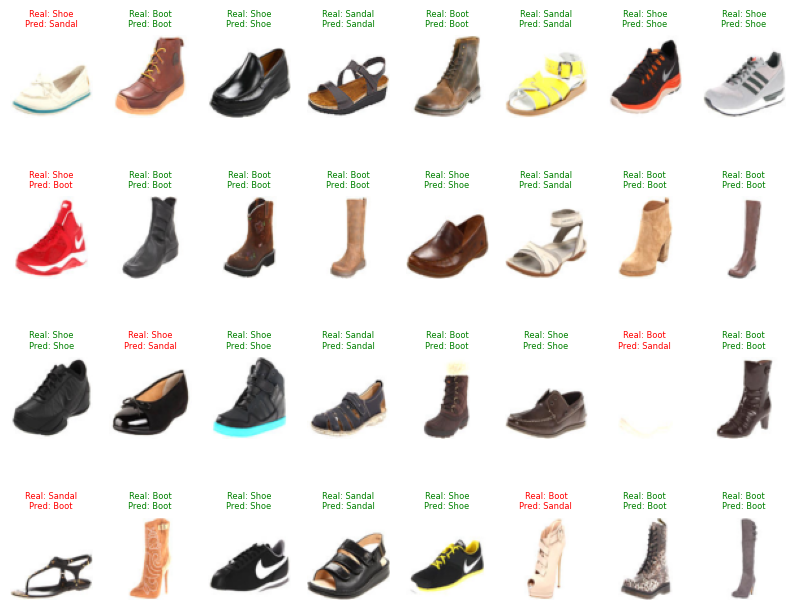

In [31]:
from helper_functions.evaluate import eval_model

torch.manual_seed(RANDOM_SEED)
random_shuffle = DataLoader(
    dataset=validation_dataloader.dataset,
    batch_size=32,
    shuffle=True,
)

eval_model(
    model=model_v0,
    dataloader=random_shuffle,
    real_labels=all_data.classes,
    device=device,
)

We can see that for the most part, our model is indeed predicting correctly. We will now plot a confusion matrix to determine where the model is getting false positives.

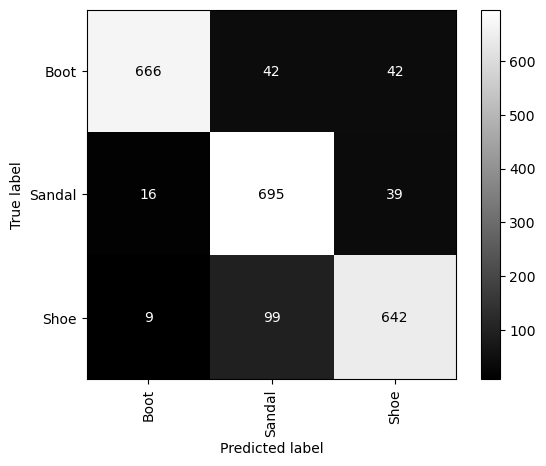

In [32]:
from helper_functions.confusion_matrix import plot_confusion_matrix

confusion_matrix = plot_confusion_matrix(
    model=model_v0,
    dataloader=validation_dataloader,
    labels=all_data.classes,
    device=device,
)
confusion_matrix.plot(cmap='gray', xticks_rotation='vertical')

In the above graph, we can see that the Shoe is getting mistaken as a Sandal the most. Furthermore, the boot is getting mistaken classified equally as a Sandal and a Shoe.

However, the model might have overfit to the training data so we should plot the loss to determine if this is so.

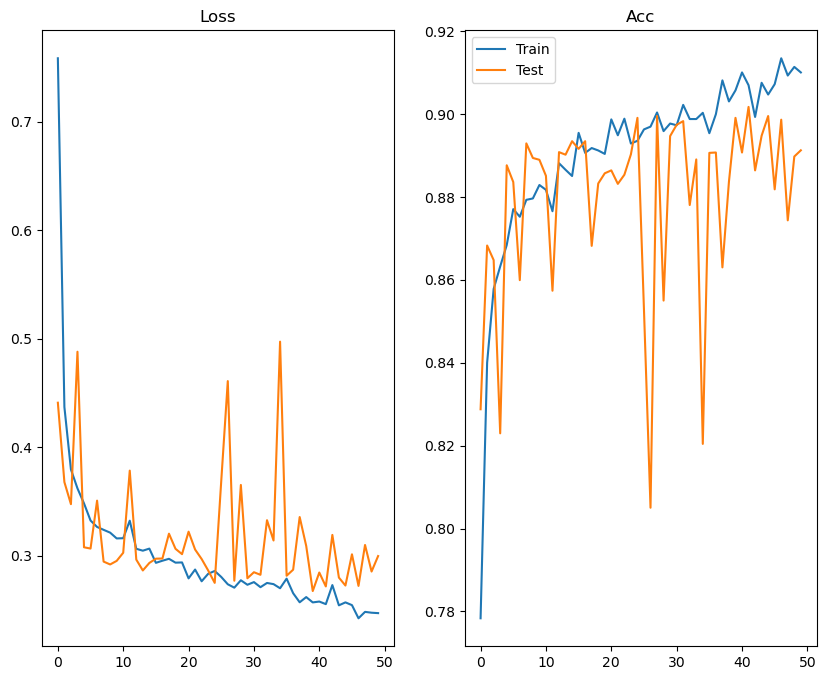

In [33]:
from helper_functions.plot_loss import plot_loss

plot_loss(model_v0_details)

As seen in the above, it seems that the model is indeed overfitting. After epochs 35, the test loss does not decrease anymore while the training loss does - indicating overfitting. Thus, let us get the best model of the data by plotting the epochs 35 to 40.

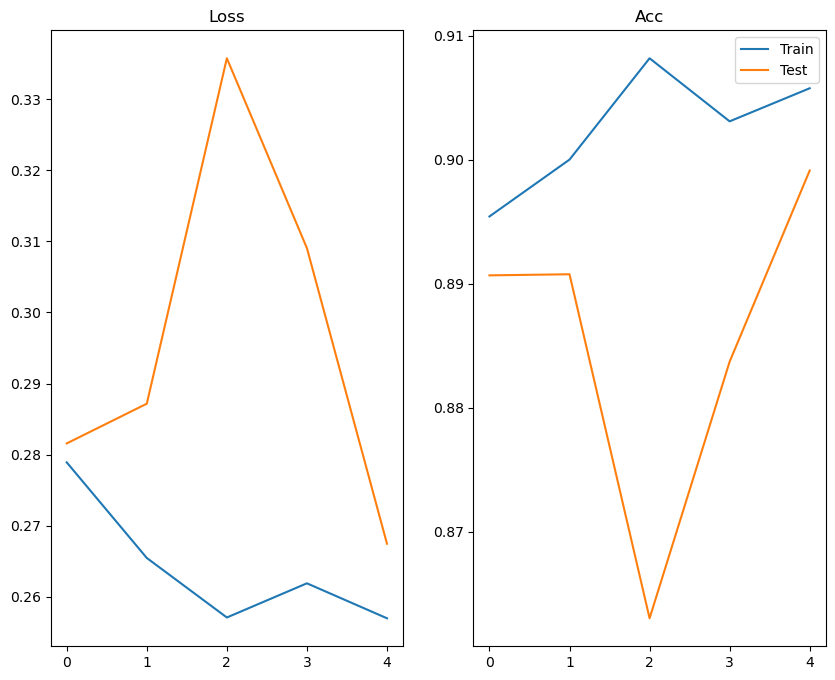

In [34]:
from helper_functions.plot_loss import plot_loss

model_v0_details_magnified = {
    'model_states': model_v0_details['model_states'][35:40],
    'train': model_v0_details['train'][35:40],
    'test': model_v0_details['test'][35:40],
}

plot_loss(model_v0_details_magnified)

As seen in the above graph, it seems that epoch 1 is the best. Thus, we will use it to evaluate the model again.

In [35]:
model_v0.load_state_dict(model_v0_details_magnified['model_states'][1])

<All keys matched successfully>

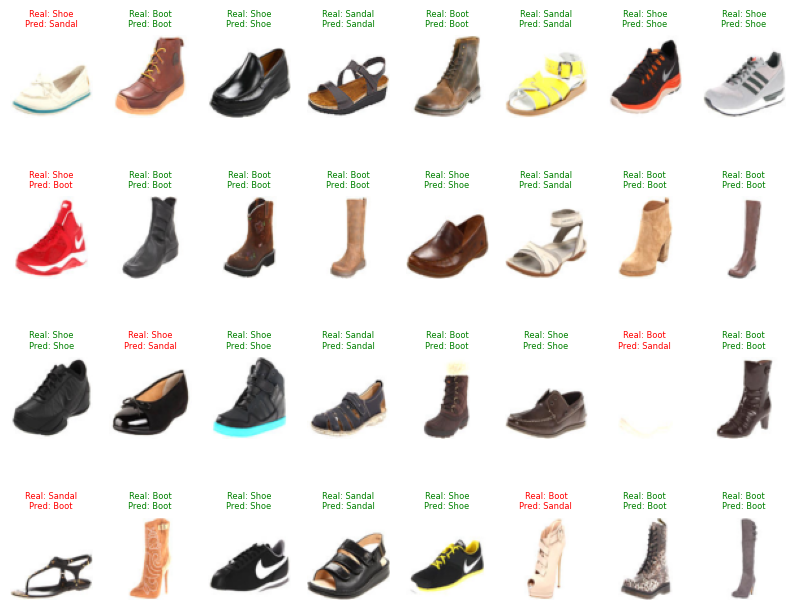

In [36]:
from helper_functions.evaluate import eval_model

torch.manual_seed(RANDOM_SEED)
random_shuffle = DataLoader(
    dataset=validation_dataloader.dataset,
    batch_size=32,
    shuffle=True,
)

eval_model(
    model=model_v0,
    dataloader=random_shuffle,
    real_labels=all_data.classes,
    device=device,
)

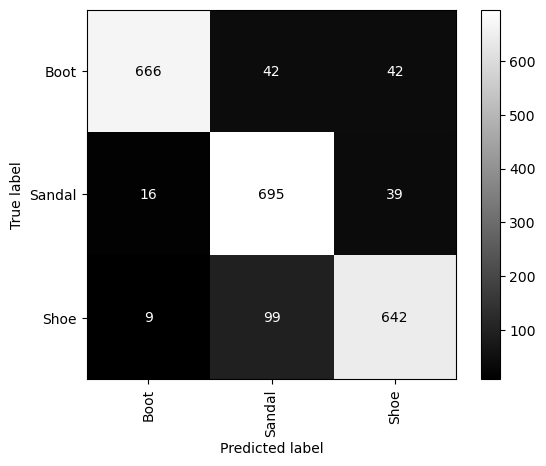

In [37]:
from helper_functions.confusion_matrix import plot_confusion_matrix

confusion_matrix = plot_confusion_matrix(
    model=model_v0,
    dataloader=validation_dataloader,
    labels=all_data.classes,
    device=device,
)
confusion_matrix.plot(cmap='gray', xticks_rotation='vertical')

With this, we can save the first model to `models/results/model_0.pt`.

In [38]:
from helper_functions.save_results import save_checkpoint
from pathlib import Path

MODEL_DIR_PATH = Path("models/results")
MODEL_DIR_PATH.mkdir(
    parents=True,
    exist_ok=True,
)

MODEL_PATH = MODEL_DIR_PATH / "model_0.pt"

save_checkpoint(
    path=MODEL_PATH,
    results=model_v0_details,
)

In [39]:
import torch

checkpoint = torch.load(MODEL_PATH)
checkpoint.keys()

dict_keys(['model_states', 'optimizer_states', 'train', 'test'])

In [40]:
len(checkpoint['model_states']), len(checkpoint['optimizer_states'])

(50, 50)

## 5. Model V1: Adding Non-Linearity

First off, ~85% accuracy for a simple model is pretty good. However, we can likely do better by adding some non-linearity layers. This is simply adding `ReLU` layers in between hidden units.

In [41]:
%%writefile models/model_v1.py
"""
Contains the code to help instantiate the linear model with `ReLU`
"""
import torch
import torch.nn as nn


class ModelV1(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_layers: int):
        """
        This creates a model with `in_features` nodes
        and predicts `out_features` nodes. The `hidden_layers`
        connect the two nodes.

        The difference between `ModelV0` and `ModelV1` is that
        `ModelV1` has a ReLU layer that allows it to
        theoretically perform better.

        :param in_features: The number of features in the image.
            This will likely be color channels multiplied by
            height and width.
        :param out_features: The number of predictors.
        :param hidden_layers: This connects the input layer and
            the output layer together so feel free to experiment
            with this hyperparameter.
        """
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=in_features,
                out_features=hidden_layers,
            ),
            nn.ReLU(),
        )

        self.layer_2 = nn.Sequential(
            nn.Linear(
                in_features=hidden_layers,
                out_features=out_features,
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.layer_1(x)
        x2 = self.layer_2(x1)

        return x2

Overwriting models/model_v1.py


In [42]:
from models.model_v1 import ModelV1

model_v1 = ModelV1(
    in_features=3 * 64 * 64,  # 3 color channels, 64 height, 64 width
    out_features=3,
    hidden_layers=16,
)
model_v1.to(device=device)
model_v1

ModelV1(
  (layer_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=16, bias=True)
    (2): ReLU()
  )
  (layer_2): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [43]:
import torchinfo

torchinfo.summary(model_v1)

Layer (type:depth-idx)                   Param #
ModelV1                                  --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       196,624
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       51
Total params: 196,675
Trainable params: 196,675
Non-trainable params: 0

In [44]:
import torch
import torch.nn as nn

loss_v1 = nn.CrossEntropyLoss()
optimizer_v1 = torch.optim.Adam(
    params=model_v1.parameters(),
    lr=0.001,
)

In [45]:
import torch
from helper_functions.result_types import TrainTestResult

model_v1_details: TrainTestResult = {
    'model_states': [],
    'optimizer_states': [],
    'train': [],
    'test': [],
}

try:
    print("Loading previous results of training...")
    model_v1_details: TrainTestResult = torch.load("./models/results/model_1.pt", map_location=device)

    model_v1.load_state_dict(model_v1_details['model_states'][-1])
    optimizer_v1.load_state_dict(model_v1_details['optimizer_states'][-1])
    print("Successfully loaded previous results of training to model and optimizer")
except FileNotFoundError:
    print("No previous results found. Starting with random values")

Loading previous results of training...
Successfully loaded previous results of training to model and optimizer


In [46]:
from sklearn.metrics import accuracy_score
from helper_functions.train_and_test import train_and_test

model_v1_details = train_and_test(
    model=model_v1,
    train_dataloader=train_dataloader,
    test_dataloader=validation_dataloader,
    loss_fn=loss_v1,
    optimizer=optimizer_v1,
    accuracy_fn=accuracy_score,
    device=device,
    epochs=50,
    previous=model_v1_details,
)

0it [00:00, ?it/s]

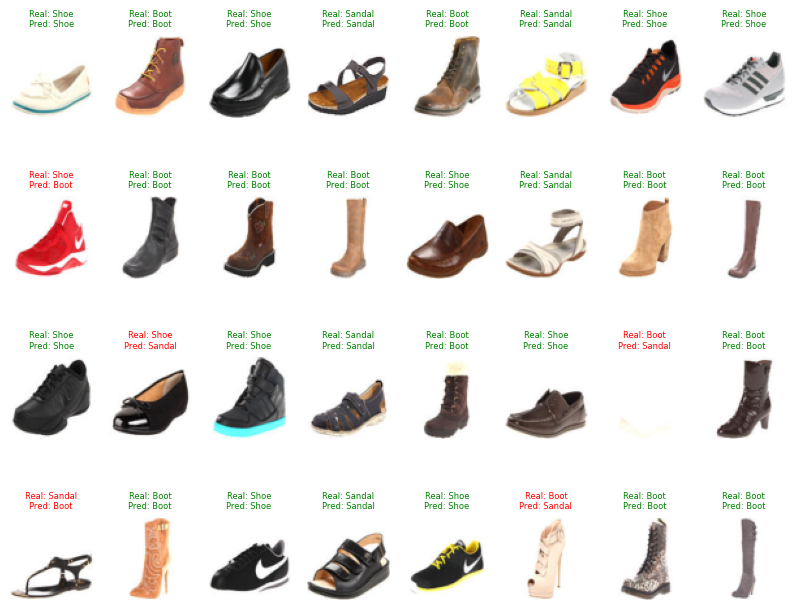

In [47]:
from helper_functions.evaluate import eval_model

torch.manual_seed(RANDOM_SEED)
random_shuffle = DataLoader(
    dataset=validation_dataloader.dataset,
    batch_size=32,
    shuffle=True,
)

eval_model(
    model=model_v1,
    dataloader=random_shuffle,
    real_labels=all_data.classes,
    device=device,
)

From the predictions above, it is clear that the second version of the model is performing better than the first model. However, this may simply be sampling bias - thus we need to plot a confusion matrix.

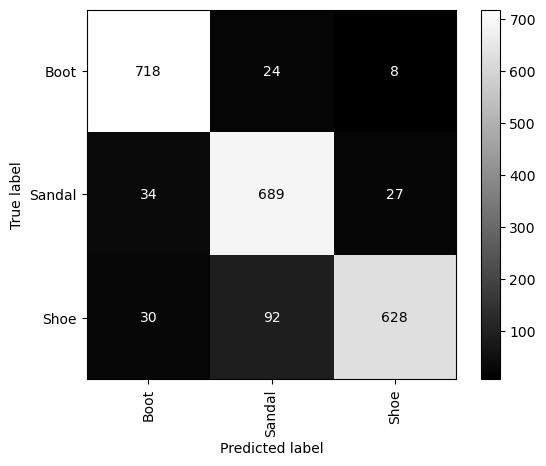

In [48]:
from helper_functions.confusion_matrix import plot_confusion_matrix

confusion_matrix = plot_confusion_matrix(
    model=model_v1,
    dataloader=validation_dataloader,
    labels=all_data.classes,
    device=device,
)
confusion_matrix.plot(cmap='gray', xticks_rotation='vertical')

From the above, it is clear that the Shoe is still getting misclassified as a Sandal sometimes but is still lower absolutely than the first model. We can now plot the loss function to determine overfitting.

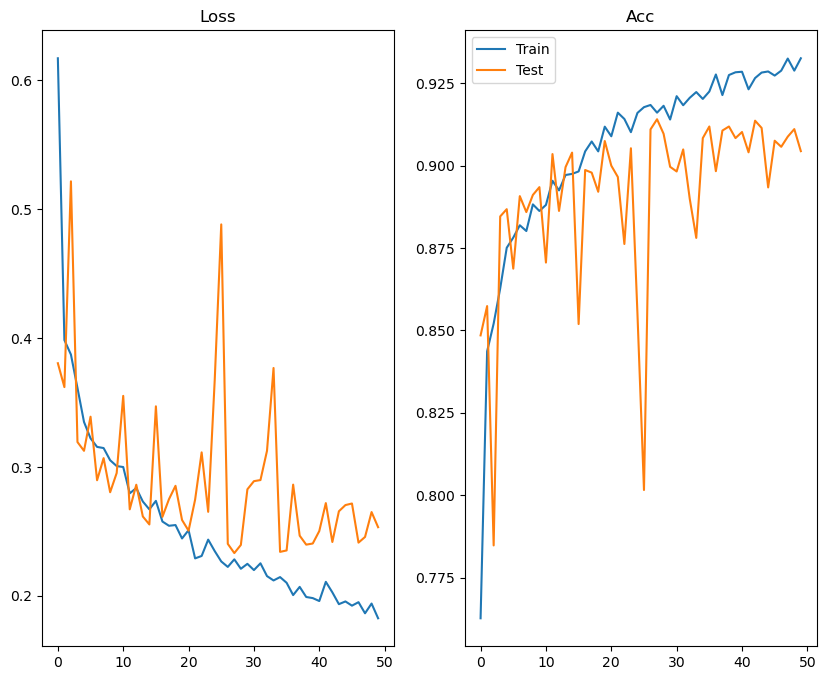

In [49]:
from helper_functions.plot_loss import plot_loss

plot_loss(model_v1_details)

From the above, it is clear that the model is overfitting right after epoch 25. The training loss is getting lower but the test loss is staying stagnant. Thus, we need to get the best performing version of the model.

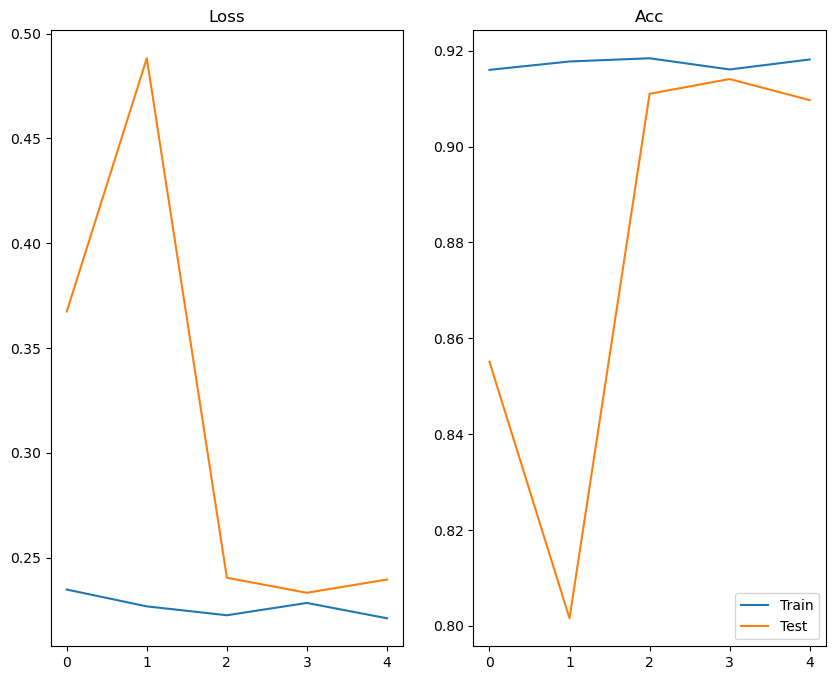

In [50]:
from helper_functions.plot_loss import plot_loss

model_v1_details_magnified = {
    'model_states': model_v1_details['model_states'][24:29],
    'train': model_v1_details['train'][24:29],
    'test': model_v1_details['test'][24:29],
}

plot_loss(model_v1_details_magnified)

From the above, it seems that epoch 3 seems to be the best performing state of `ModelV1`. Thus, we will use it to represent it.

In [51]:
model_v1.load_state_dict(model_v1_details_magnified['model_states'][3])

<All keys matched successfully>

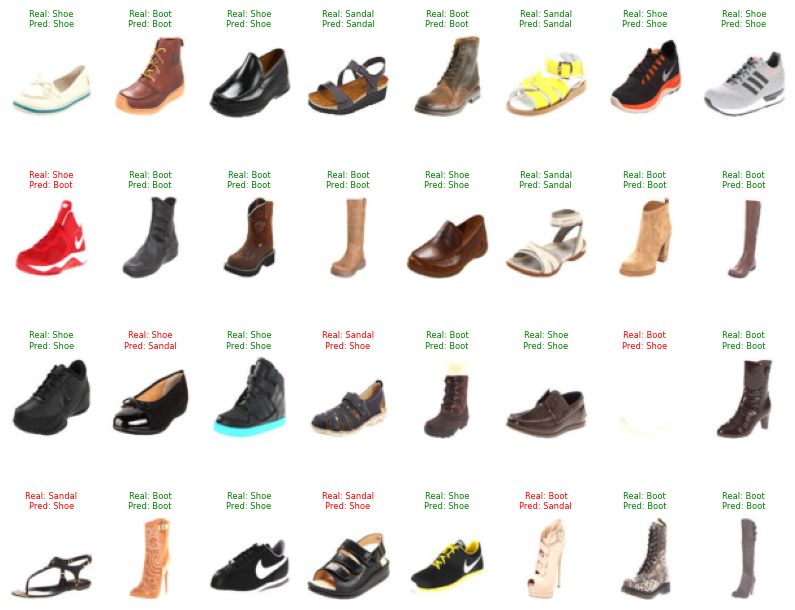

In [52]:
from helper_functions.evaluate import eval_model

torch.manual_seed(RANDOM_SEED)
random_shuffle = DataLoader(
    dataset=validation_dataloader.dataset,
    batch_size=32,
    shuffle=True,
)

eval_model(
    model=model_v1,
    dataloader=random_shuffle,
    real_labels=all_data.classes,
    device=device,
)

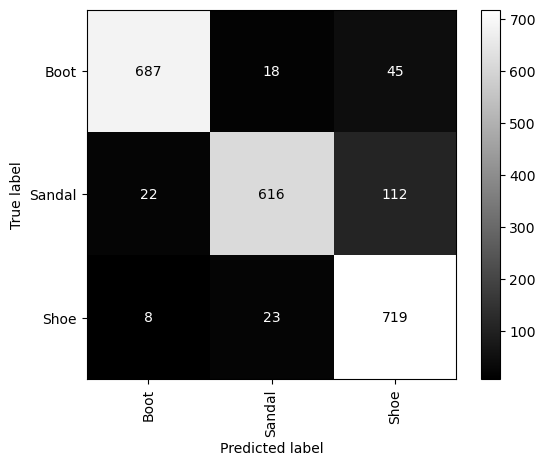

In [53]:
from helper_functions.confusion_matrix import plot_confusion_matrix

confusion_matrix = plot_confusion_matrix(
    model=model_v1,
    dataloader=validation_dataloader,
    labels=all_data.classes,
    device=device,
)
confusion_matrix.plot(cmap='gray', xticks_rotation='vertical')

From the confusion matrix above, it seems that the most common false positive is now the sandal getting mistakenly classified as a shoe.

In [54]:
from helper_functions.save_results import save_checkpoint
from pathlib import Path

MODEL_DIR_PATH = Path("models/results")
MODEL_DIR_PATH.mkdir(
    parents=True,
    exist_ok=True,
)

MODEL_PATH = MODEL_DIR_PATH / "model_1.pt"

save_checkpoint(
    path=MODEL_PATH,
    results=model_v1_details,
)

In [55]:
import torch

checkpoint = torch.load(MODEL_PATH)
checkpoint.keys()

dict_keys(['model_states', 'optimizer_states', 'train', 'test'])

In [56]:
len(checkpoint['model_states']), len(checkpoint['optimizer_states'])

(50, 50)

## 6. Model V2: One hidden layer

After `ModelV1` added non-linear layers, we will now test whether adding a third hidden layer with `hidden_layers` as input and `hidden_layers` as output helps improve the accuracy of the model.

In [57]:
%%writefile models/model_v2.py
"""
Contains the code to help instantiate the linear model with another hidden layer
"""
import torch
import torch.nn as nn


class ModelV2(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_layers: int):
        """
        This creates a model with `in_features` nodes
        and predicts `out_features` nodes. The `hidden_layers`
        connect the two nodes.

        Its difference from `ModelV1` is that `ModelV2` adds
        a hidden layer that has `hidden_layers` as input and
        `hidden_layers` as output.

        :param in_features: The number of features in the image.
            This will likely be color channels multiplied by
            height and width.
        :param out_features: The number of predictors.
        :param hidden_layers: This connects the input layer and
            the output layer together so feel free to experiment
            with this hyperparameter.
        """
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=in_features,
                out_features=hidden_layers,
            ),
            nn.ReLU(),
        )

        self.layer_2 = nn.Sequential(
            nn.Linear(
                in_features=hidden_layers,
                out_features=hidden_layers,
            ),
            nn.ReLU(),
        )

        self.layer_3 = nn.Sequential(
            nn.Linear(
                in_features=hidden_layers,
                out_features=out_features,
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.layer_1(x)
        x2 = self.layer_2(x1)
        x3 = self.layer_3(x2)

        return x3

Overwriting models/model_v2.py


In [58]:
from models.model_v2 import ModelV2

model_v2 = ModelV2(
    in_features=3 * 64 * 64,  # 3 color channels, 64 height, 64 width
    out_features=3,
    hidden_layers=16,
)
model_v2.to(device=device)
model_v2

ModelV2(
  (layer_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=16, bias=True)
    (2): ReLU()
  )
  (layer_2): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer_3): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [59]:
import torchinfo

torchinfo.summary(model_v2)

Layer (type:depth-idx)                   Param #
ModelV2                                  --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       196,624
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       272
│    └─ReLU: 2-5                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-6                       51
Total params: 196,947
Trainable params: 196,947
Non-trainable params: 0

In [60]:
import torch
import torch.nn as nn

loss_v2 = nn.CrossEntropyLoss()
optimizer_v2 = torch.optim.Adam(
    params=model_v2.parameters(),
    lr=0.001,
)

In [61]:
import torch
from helper_functions.result_types import TrainTestResult

model_v2_details: TrainTestResult = {
    'model_states': [],
    'optimizer_states': [],
    'train': [],
    'test': [],
}

try:
    print("Loading previous results of training...")
    model_v2_details: TrainTestResult = torch.load("./models/results/model_2.pt", map_location=device)

    model_v2.load_state_dict(model_v2_details['model_states'][-1])
    optimizer_v2.load_state_dict(model_v2_details['optimizer_states'][-1])
    print("Successfully loaded previous results of training to model and optimizer")
except FileNotFoundError:
    print("No previous results found. Starting with random values")

Loading previous results of training...
Successfully loaded previous results of training to model and optimizer


In [62]:
from sklearn.metrics import accuracy_score
from helper_functions.train_and_test import train_and_test

model_v2_details = train_and_test(
    model=model_v2,
    train_dataloader=train_dataloader,
    test_dataloader=validation_dataloader,
    loss_fn=loss_v2,
    optimizer=optimizer_v2,
    accuracy_fn=accuracy_score,
    device=device,
    epochs=50,
    previous=model_v2_details,
)

0it [00:00, ?it/s]

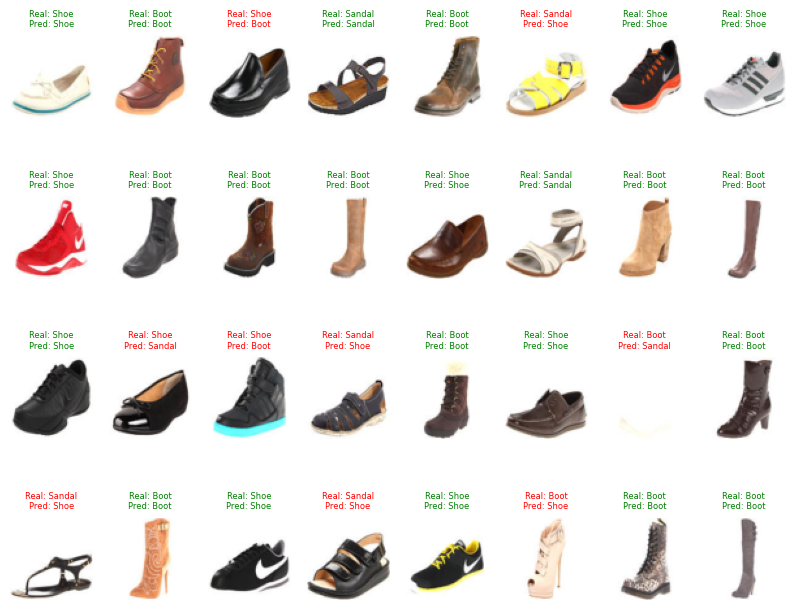

In [63]:
from helper_functions.evaluate import eval_model

torch.manual_seed(RANDOM_SEED)
random_shuffle = DataLoader(
    dataset=validation_dataloader.dataset,
    batch_size=32,
    shuffle=True,
)

eval_model(
    model=model_v2,
    dataloader=random_shuffle,
    real_labels=all_data.classes,
    device=device,
)

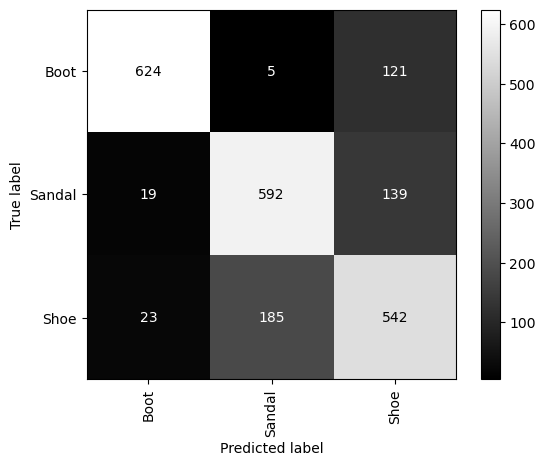

In [64]:
from helper_functions.confusion_matrix import plot_confusion_matrix

confusion_matrix = plot_confusion_matrix(
    model=model_v2,
    dataloader=validation_dataloader,
    labels=all_data.classes,
    device=device,
)
confusion_matrix.plot(cmap='gray', xticks_rotation='vertical')

As we did in `ModelV0` and `ModelV1`, we will plot the loss to determine the best epoch.

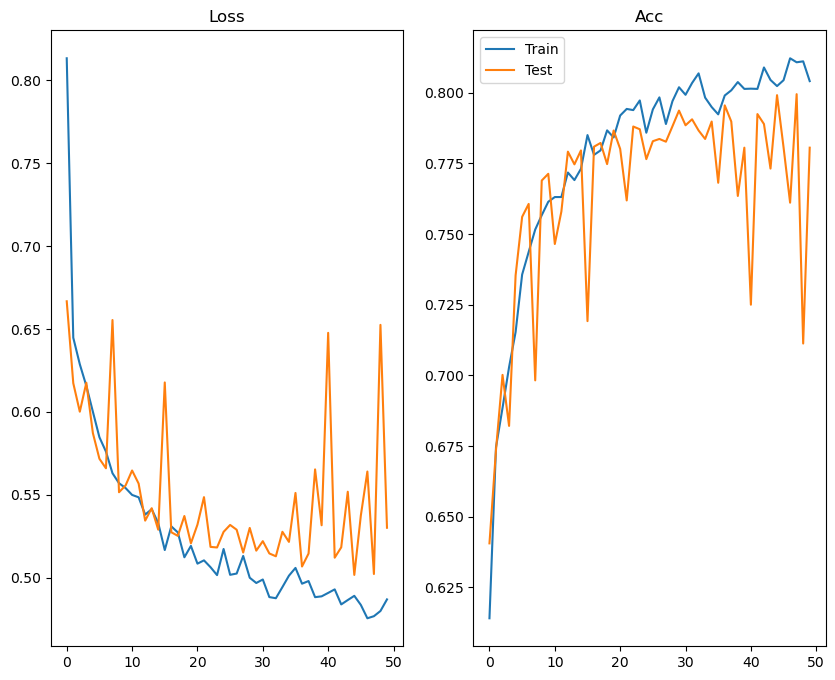

In [65]:
from helper_functions.plot_loss import plot_loss

plot_loss(model_v2_details)

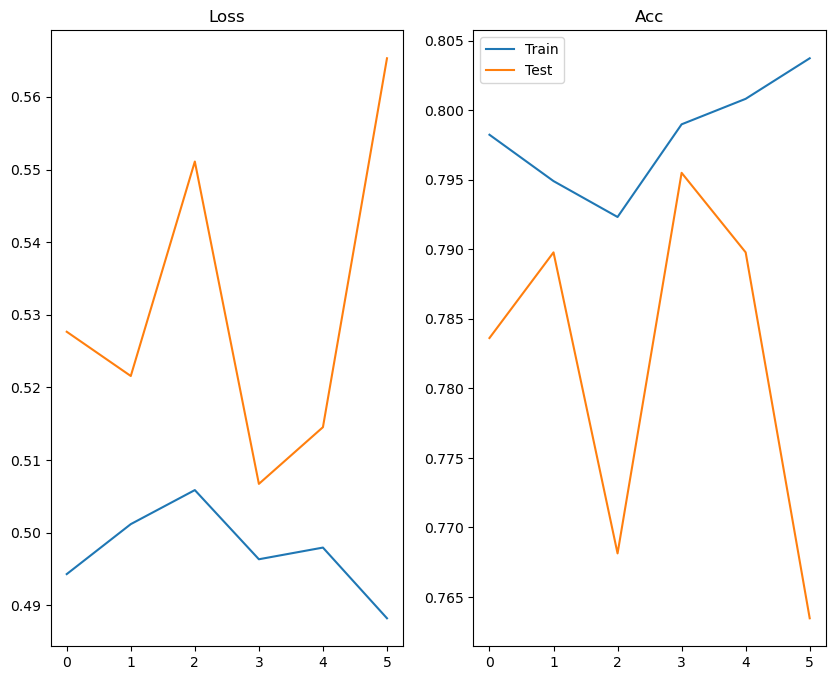

In [66]:
from helper_functions.plot_loss import plot_loss

model_v2_details_magnified = {
    'model_states': model_v2_details['model_states'][33:39],
    'train': model_v2_details['train'][33:39],
    'test': model_v2_details['test'][33:39],
}

plot_loss(model_v2_details_magnified)

From the above graph, epoch 3 seems to be the best and so will be used by `ModelV2`.

In [67]:
model_v2.load_state_dict(model_v2_details_magnified['model_states'][3])

<All keys matched successfully>

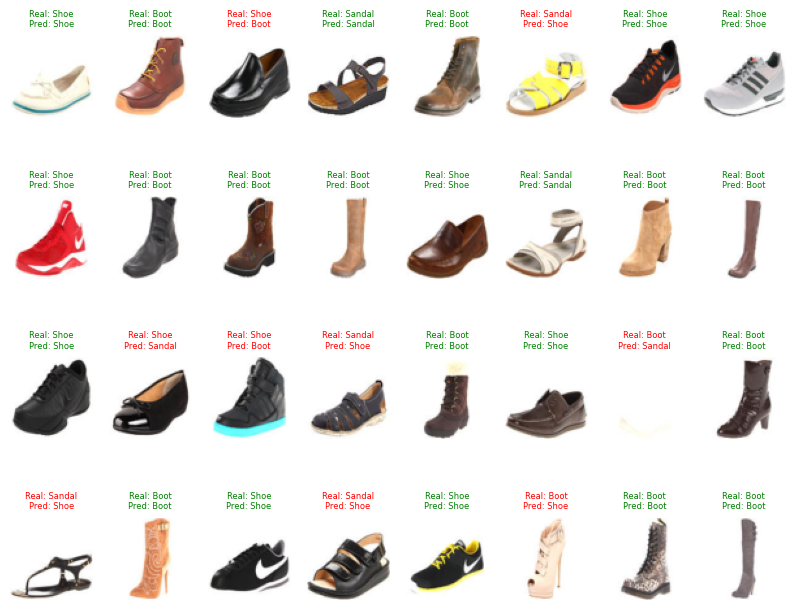

In [69]:
from helper_functions.evaluate import eval_model

torch.manual_seed(RANDOM_SEED)
random_shuffle = DataLoader(
    dataset=validation_dataloader.dataset,
    batch_size=32,
    shuffle=True,
)

eval_model(
    model=model_v2,
    dataloader=random_shuffle,
    real_labels=all_data.classes,
    device=device,
)

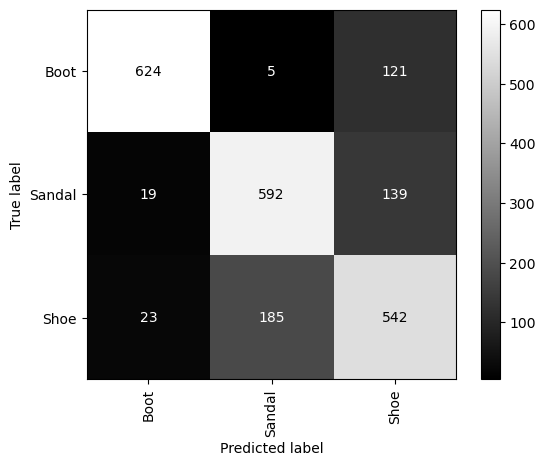

In [71]:
from helper_functions.confusion_matrix import plot_confusion_matrix

confusion_matrix = plot_confusion_matrix(
    model=model_v2,
    dataloader=validation_dataloader,
    labels=all_data.classes,
    device=device,
)
confusion_matrix.plot(cmap='gray', xticks_rotation='vertical')

This is currently the first model that has a worse performance than the former model. It is now making more false predictions than the previous models and overall less true predictions.

In [72]:
from helper_functions.save_results import save_checkpoint
from pathlib import Path

MODEL_DIR_PATH = Path("models/results")
MODEL_DIR_PATH.mkdir(
    parents=True,
    exist_ok=True,
)

MODEL_PATH = MODEL_DIR_PATH / "model_2.pt"

save_checkpoint(
    path=MODEL_PATH,
    results=model_v2_details,
)

In [73]:
import torch

checkpoint = torch.load(MODEL_PATH)
checkpoint.keys()

dict_keys(['model_states', 'optimizer_states', 'train', 'test'])

In [74]:
len(checkpoint['model_states']), len(checkpoint['optimizer_states'])

(50, 50)

## 7. Model V3: Convolutional Neural Network

Finally, we will be using convolutional neural networks. CNNs are known to perform really well for images and as such, I expect this model to perform the best of the four models. We will be using three layers:

1. The first layer consists of a Convolutional layer with a kernel size of `3, 3` and stride of `1, 1`. It will be max pooled at the end with the same parameters.
2. The second layer is similar to the first layer's parameters.
3. The final layer is a flattened layer and uses a linear layer for prediction.

In order to find out the number of `in_features` for the final linear layer, the researchers simply used a forward pass of a similar input. This will be explained in more detail in the next section.

In [75]:
%%writefile models/model_v3.py
"""
Contains the code to help instantiate the a model using CNN
"""
import torch
import torch.nn as nn


class ModelV3(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_layers: int):
        """
        This creates a model with `in_features` nodes
        and predicts `out_features` nodes. The `hidden_layers`
        connect the two nodes.

        :param in_features: The number of features in the image.
            This will likely be color channels. Do NOT multiply by
            height and width as this uses Convolutional Neural
            Networks.
        :param out_features: The number of predictors.
        :param hidden_layers: This connects the input layer and
            the output layer together so feel free to experiment
            with this hyperparameter.
        """
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_features,
                out_channels=hidden_layers,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_layers,
                out_channels=hidden_layers,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=0,
            ),
        )

        self.layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_layers,
                out_channels=hidden_layers,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_layers,
                out_channels=hidden_layers,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=0,
            )
        )

        self.layer_3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=43264,
                out_features=out_features,
            ),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.layer_1(x)
        x2 = self.layer_2(x1)
        x3 = self.layer_3(x2)

        return x3

Overwriting models/model_v3.py


In [76]:
from models.model_v3 import ModelV3

model_v3 = ModelV3(
    in_features=3,  # 3 color channels
    out_features=3,
    hidden_layers=16,
)
model_v3.to(device=device)
model_v3

ModelV3(
  (layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=43264, out_features=3, bias=True)
  )
)

As stated in the beginning section, I did a forward pass to help determine the shape of the final sequential layer. Instead of doing some hard math, I wrote the code below instead. On the first run when the `in_features` parameter has been set incorrectly, the code above should indicate a shape error which can be used as a guide to determine the number of input parameters for the linear layer.

In [77]:
# The code below is to help figure out the shape of the
# tensor for x3 in the forward pass

rand = torch.randn((1, 3, 64, 64)).to(device=device)
model_v3(rand)

tensor([[ 0.0821, -0.0168, -0.0310]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [78]:
import torchinfo

torchinfo.summary(model_v3)

Layer (type:depth-idx)                   Param #
ModelV3                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       448
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       2,320
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       2,320
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       2,320
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      129,795
Total params: 137,203
Trainable params: 137,203
Non-trainable params: 0

In [79]:
import torch
import torch.nn as nn

loss_v3 = nn.CrossEntropyLoss()
optimizer_v3 = torch.optim.Adam(
    params=model_v3.parameters(),
    lr=0.001,
)

In [80]:
import torch
from helper_functions.result_types import TrainTestResult

model_v3_details: TrainTestResult = {
    'model_states': [],
    'optimizer_states': [],
    'train': [],
    'test': [],
}

try:
    print("Loading previous results of training...")
    model_v3_details: TrainTestResult = torch.load("./models/results/model_3.pt", map_location=device)

    model_v3.load_state_dict(model_v3_details['model_states'][-1])
    optimizer_v3.load_state_dict(model_v3_details['optimizer_states'][-1])
    print("Successfully loaded previous results of training to model and optimizer")
except FileNotFoundError:
    print("No previous results found. Starting with random values")

Loading previous results of training...
Successfully loaded previous results of training to model and optimizer


In [81]:
from sklearn.metrics import accuracy_score
from helper_functions.train_and_test import train_and_test

model_v3_details = train_and_test(
    model=model_v3,
    train_dataloader=train_dataloader,
    test_dataloader=validation_dataloader,
    loss_fn=loss_v3,
    optimizer=optimizer_v3,
    accuracy_fn=accuracy_score,
    device=device,
    epochs=35,
    previous=model_v3_details,
)

0it [00:00, ?it/s]

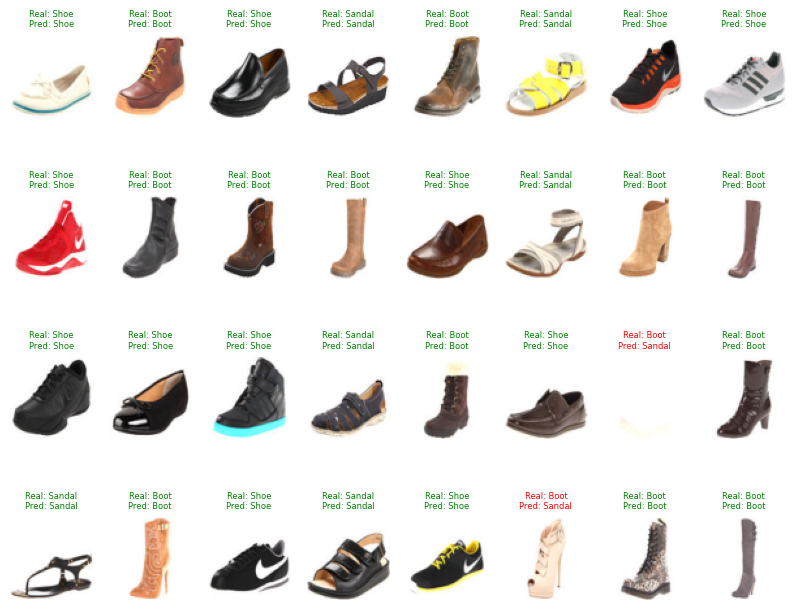

In [82]:
from helper_functions.evaluate import eval_model

torch.manual_seed(RANDOM_SEED)
random_shuffle = DataLoader(
    dataset=validation_dataloader.dataset,
    batch_size=32,
    shuffle=True,
)

eval_model(
    model=model_v3,
    dataloader=random_shuffle,
    real_labels=all_data.classes,
    device=device,
)

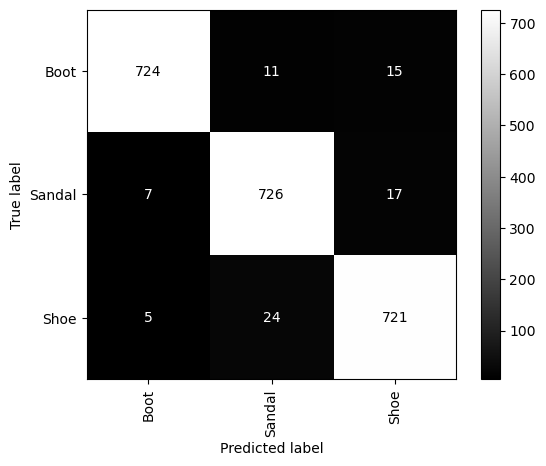

In [83]:
from helper_functions.confusion_matrix import plot_confusion_matrix

confusion_matrix = plot_confusion_matrix(
    model=model_v3,
    dataloader=validation_dataloader,
    labels=all_data.classes,
    device=device,
)
confusion_matrix.plot(cmap='gray', xticks_rotation='vertical')

Like the previous models, we will plot the losses to see the best epoch of the model.

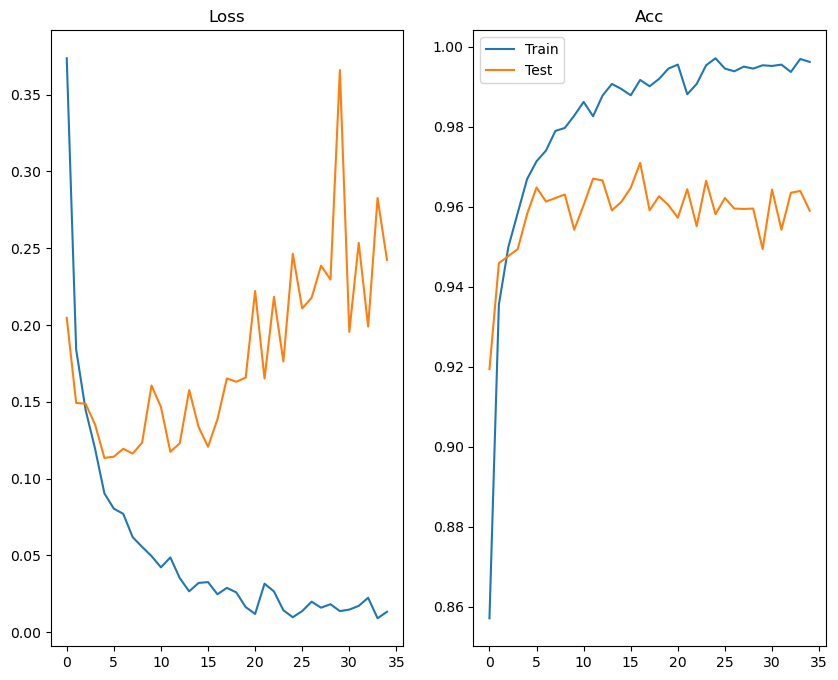

In [84]:
from helper_functions.plot_loss import plot_loss

plot_loss(model_v3_details)

From the above graphs, it is shown that at around epoch 4 and epoch 5, the model is starting to overfit. Thus, we will only use the weights for epochs 4 to 8. To figure out the exact epoch, let's print first the epochs 4 to 8:

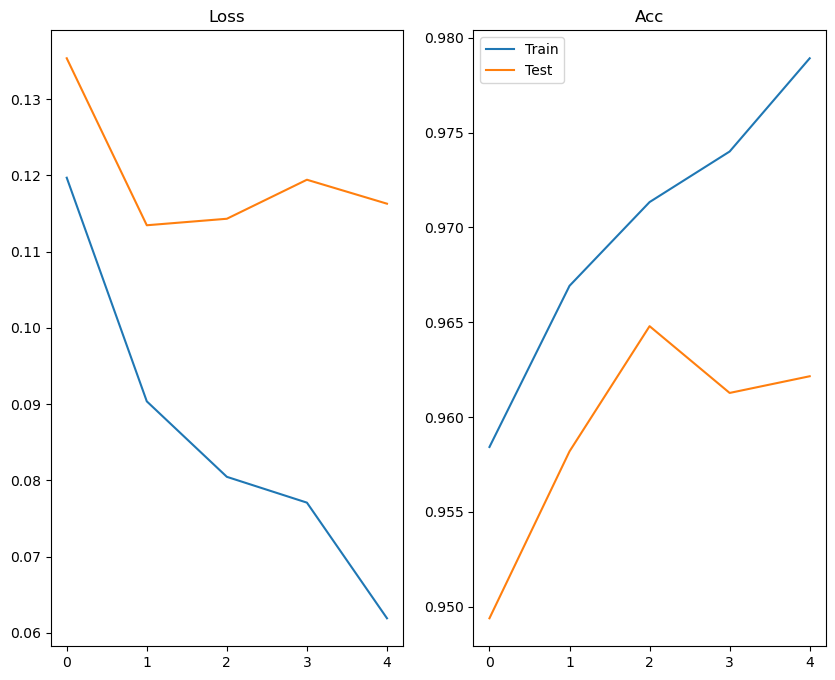

In [85]:
from helper_functions.plot_loss import plot_loss

model_v3_details_magnified = {
    'model_states': model_v3_details['model_states'][3:8],
    'train': model_v3_details['train'][3:8],
    'test': model_v3_details['test'][3:8],
}

plot_loss(model_v3_details_magnified)

From the graph above, epoch 1 has the best training weight for the final model. We will then evaluate the entire model again and evaluate the false positives.

In [86]:
model_v3.load_state_dict(model_v3_details_magnified['model_states'][2])

<All keys matched successfully>

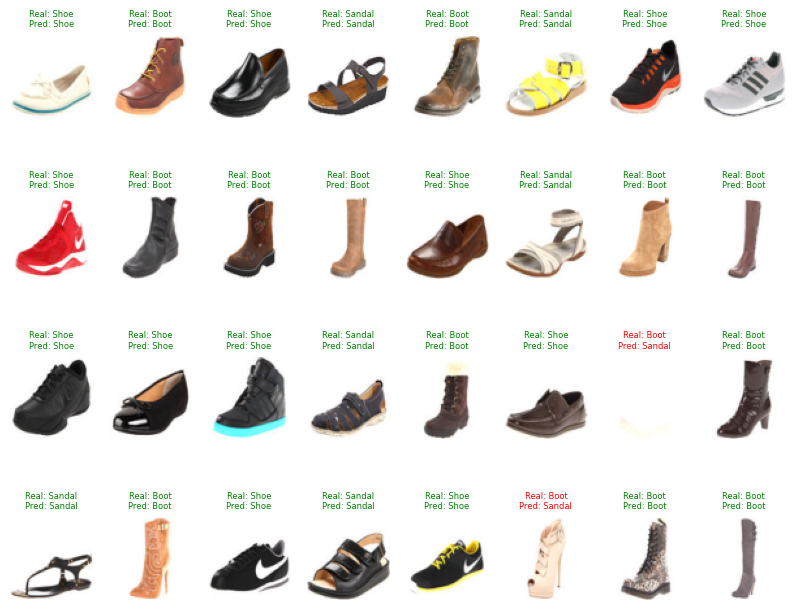

In [87]:
from helper_functions.evaluate import eval_model

torch.manual_seed(RANDOM_SEED)
random_shuffle = DataLoader(
    dataset=validation_dataloader.dataset,
    batch_size=32,
    shuffle=True,
)

eval_model(
    model=model_v3,
    dataloader=random_shuffle,
    real_labels=all_data.classes,
    device=device,
)

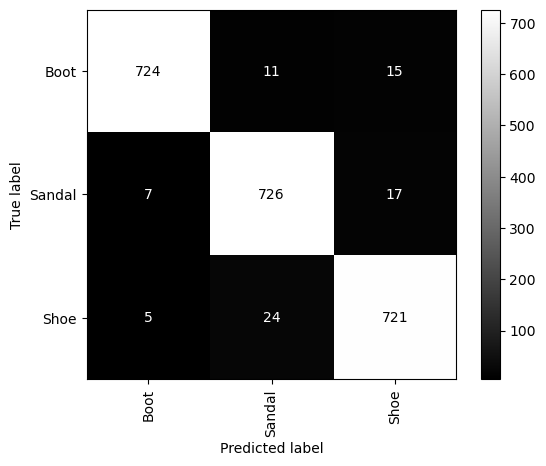

In [88]:
from helper_functions.confusion_matrix import plot_confusion_matrix

confusion_matrix = plot_confusion_matrix(
    model=model_v3,
    dataloader=validation_dataloader,
    labels=all_data.classes,
    device=device,
)
confusion_matrix.plot(cmap='gray', xticks_rotation='vertical')

From the looks of it, the final model looks like it is the most accurate. However, we will figure this out later in the next section.

In [89]:
from helper_functions.save_results import save_checkpoint
from pathlib import Path

MODEL_DIR_PATH = Path("models/results")
MODEL_DIR_PATH.mkdir(
    parents=True,
    exist_ok=True,
)

MODEL_PATH = MODEL_DIR_PATH / "model_3.pt"

save_checkpoint(
    path=MODEL_PATH,
    results=model_v3_details,
)

In [90]:
import torch

checkpoint = torch.load(MODEL_PATH)
checkpoint.keys()

dict_keys(['model_states', 'optimizer_states', 'train', 'test'])

In [91]:
len(checkpoint['model_states']), len(checkpoint['optimizer_states'])

(35, 35)

## 8. Comparing and Evaluating Models

We will now compare and evaluate all four models side by side. Since we already saved the best model of the previous runs, we can start using the validation dataloader to compare them all.

First, we will see the structures of all the models again.

In [92]:
model_v0

ModelV0(
  (layer_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=16, bias=True)
  )
  (layer_2): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [93]:
model_v1

ModelV1(
  (layer_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=16, bias=True)
    (2): ReLU()
  )
  (layer_2): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [94]:
model_v2

ModelV2(
  (layer_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=16, bias=True)
    (2): ReLU()
  )
  (layer_2): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer_3): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [95]:
model_v3

ModelV3(
  (layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=43264, out_features=3, bias=True)
  )
)

### 8.1 Getting the Accuracy of Each Model

With the above four models, we will create a convenience function that evaluates a model.

In [97]:
import torch
import torch.nn as nn
from typing import Callable

def evaluate_model_accuracy(
        model: nn.Module,
        dataloader: torch.utils.data.DataLoader,
        accuracy_fn: Callable[..., float],
        device: torch.device,
) -> float:
    """
    This is a helper function that evaluates a model's
    accuracy.

    :param model: A model to be trained
    :param dataloader: This will ideally be the validation
        dataloader. Only use the test dataloader at your last
        step as choosing the best model can still be arguably
        a hyperparameter.
    :param accuracy_fn: A function that calculates the
        accuracy of a model in predicting the result.
    :param device: The device in which the model should
        be trained. Ideally, this is a constant variable
    :return: The training accuracy as a float value.
    """
    model.eval()
    total_acc = 0

    with torch.inference_mode():
        for image, label in dataloader:
            image, label = image.to(device=device), label.to(device=device)

            preds = model(image)
            preds = preds.argmax(dim=1)

            acc = accuracy_fn(label.cpu(), preds.cpu())
            total_acc += acc

    return total_acc / len(dataloader)

In [98]:
model_v0_acc = evaluate_model_accuracy(
        model=model_v0,
        dataloader=validation_dataloader,
        accuracy_fn=accuracy_score,
        device=device,
)
model_v0_acc

0.8912852112676056

In [99]:
model_v1_acc = evaluate_model_accuracy(
        model=model_v1,
        dataloader=validation_dataloader,
        accuracy_fn=accuracy_score,
        device=device,
)
model_v1_acc

0.8996478873239436

In [100]:
model_v2_acc = evaluate_model_accuracy(
        model=model_v2,
        dataloader=validation_dataloader,
        accuracy_fn=accuracy_score,
        device=device,
)
model_v2_acc

0.7805457746478873

In [101]:
model_v3_acc = evaluate_model_accuracy(
        model=model_v3,
        dataloader=validation_dataloader,
        accuracy_fn=accuracy_score,
        device=device,
)
model_v3_acc

0.9642605633802818

With the above numerical values, it is clear that `ModelV3` has the highest accuracy. However, we will graph the three first in a bar graph to clearly show it.

<BarContainer object of 4 artists>

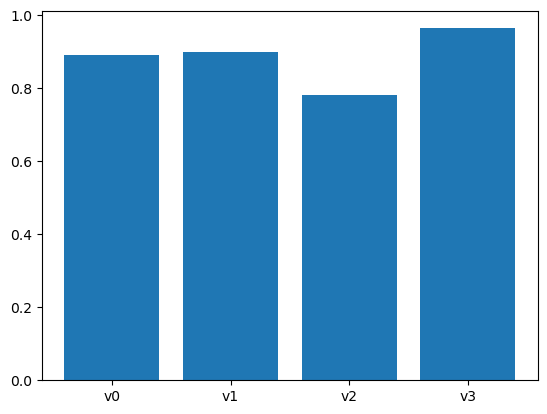

In [102]:
import matplotlib.pyplot as plt

data = {
    'v0': model_v0_acc,
    'v1': model_v1_acc,
    'v2': model_v2_acc,
    'v3': model_v3_acc,
}

plt.bar(
    data.keys(),
    data.values(),
)

We can now confidently say that `ModelV3` is the best model and as such, we will use it for evaluating the test dataset.

In [103]:
from models.model_v3 import ModelV3

best_model = ModelV3(
    in_features=3,
    out_features=3,
    hidden_layers=16,
)
best_model.to(device=device)
best_model.load_state_dict(model_v3.state_dict())
best_model

ModelV3(
  (layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=43264, out_features=3, bias=True)
  )
)

### 8.2 Evaluating Best-Performing Model

Since we now know the best performing model, we can now touch the test dataloader and get the final accuracy of our model. With running the below code and a `RANDOM_SEED` of 10, we get a 95.5357% accuracy in predicting whether something is a shoe, sandal, or a boot.

In [104]:
best_model_acc = evaluate_model_accuracy(
    model=best_model,
    dataloader=test_dataloader,
    accuracy_fn=accuracy_score,
    device=device,
)
best_model_acc

0.9553571428571428

## 9. Saving the Model

With this, we will now use `torch.save` to save the best weights of the model to its own `.pt` file.

In [105]:
from pathlib import Path

MODEL_DIR_PATH = Path("models/results")
MODEL_DIR_PATH.mkdir(
    parents=True,
    exist_ok=True,
)

In [106]:
MODEL_PATH = MODEL_DIR_PATH / "best_model.pt"
torch.save(obj=best_model.state_dict(), f=MODEL_PATH)